In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import shap

# 1 - Data Preprocessing

In [21]:
def processar_dados_ano(caminho_arquivo, escolas_comuns):
    df = pd.read_csv(caminho_arquivo, encoding='latin1', delimiter=';')
    df = df[df['CO_ENTIDADE'].isin(escolas_comuns)] 
    colunas_para_remover = [col for col in df.columns if (col.startswith('DS_') or col.startswith('NU_') or col.startswith('DT_') or col.startswith('CO_') or col.startswith('NO_')) and col != 'NU_ANO_CENSO']
    df_limpo = df.drop(columns=colunas_para_remover).drop(columns=['SG_UF'])
    colunas_com_nan = df_limpo.columns[df_limpo.isnull().any()].tolist()
    return df_limpo, colunas_com_nan

diretorio = 'dataset/'
primeiro_ano = 2012
caminho_arquivo = f'{diretorio}microdados_ed_basica_{primeiro_ano}_alagoas.csv'
df_primeiro_ano = pd.read_csv(caminho_arquivo, encoding='latin1', delimiter=';')
escolas_comuns = set(df_primeiro_ano['CO_ENTIDADE'].unique())

for ano in range(primeiro_ano + 1, 2022):
    caminho_arquivo = f'{diretorio}microdados_ed_basica_{ano}_alagoas.csv'
    df = pd.read_csv(caminho_arquivo, encoding='latin1', delimiter=';')
    escolas_comuns = escolas_comuns.intersection(set(df['CO_ENTIDADE'].unique()))

dfs = [] 

for ano in range(primeiro_ano, 2022):
    caminho_arquivo = f'{diretorio}microdados_ed_basica_{ano}_alagoas.csv'
    df_limpo, colunas_com_nan = processar_dados_ano(caminho_arquivo, escolas_comuns)
    dfs.append(df_limpo) 
    print(f"Resumo dos dados de {ano}:")
    print(colunas_com_nan)
    print("--------------------------------------------------------------------\n")
    print(df_limpo.describe())

Resumo dos dados de 2012:
[]
--------------------------------------------------------------------

       NU_ANO_CENSO  TP_DEPENDENCIA  TP_CATEGORIA_ESCOLA_PRIVADA  \
count        2838.0     2838.000000                  2838.000000   
mean         2012.0        2.984144                     0.132135   
std             0.0        0.479501                     0.476981   
min          2012.0        1.000000                     0.000000   
25%          2012.0        3.000000                     0.000000   
50%          2012.0        3.000000                     0.000000   
75%          2012.0        3.000000                     0.000000   
max          2012.0        4.000000                     4.000000   

       TP_LOCALIZACAO  TP_LOCALIZACAO_DIFERENCIADA  TP_SITUACAO_FUNCIONAMENTO  \
count     2838.000000                  2838.000000                2838.000000   
mean         1.523256                     0.071529                   1.036998   
std          0.499547                     0.4

In [22]:
df_consolidado = pd.concat(dfs)
df_consolidado.to_csv('df_consolidado.csv', index=False)

In [23]:
correlacao = df_consolidado.corr()

limiar_correlacao = 0.70
correlacoes_fortes = correlacao[(np.abs(correlacao) > limiar_correlacao) & (correlacao != 1.0)]

variaveis_fortes = correlacoes_fortes.dropna(axis=0, how='all').dropna(axis=1, how='all')
variaveis_fortes_lista = variaveis_fortes.index.tolist()

df_consolidado = df_consolidado[variaveis_fortes_lista]

In [24]:
split_percentage = 0.9
split_index = int(split_percentage * len(df_consolidado))
train_data = df_consolidado.iloc[:split_index]
test_data = df_consolidado.iloc[split_index:]

In [30]:
# Identificar colunas contínuas e categóricas
colunas_continuas = [col for col in df_consolidado.columns if col.startswith('QT_') and col != 'QT_MAT_BAS']
colunas_categoricas = [col for col in df_consolidado.columns if not col.startswith('QT_')]
# Normalizar variáveis contínuas
scaler_continuas = MinMaxScaler()
scaler_continuas.fit(train_data[colunas_continuas])
scaled_train_data_continuas = scaler_continuas.transform(train_data[colunas_continuas])
scaled_test_data_continuas = scaler_continuas.transform(test_data[colunas_continuas])
scaled_train_data = np.hstack((scaled_train_data_continuas, train_data[colunas_categoricas].values))
scaled_test_data = np.hstack((scaled_test_data_continuas, test_data[colunas_categoricas].values))

In [31]:
def timeseries_preprocessing(scaled_train_data, scaled_test_data, target_train, target_test, time_steps):
    x_train, y_train = [], []
    x_test, y_test = [], []

    for i in range(time_steps, len(scaled_train_data)):
        x_train.append(scaled_train_data[i - time_steps:i])
        y_train.append(target_train[i])

    for i in range(time_steps, len(scaled_test_data)):
        x_test.append(scaled_test_data[i - time_steps:i])
        y_test.append(target_test[i])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    return x_train, y_train, x_test, y_test


target_train = train_data['QT_MAT_BAS'].values
target_test = test_data['QT_MAT_BAS'].values
time_steps = 10
x_train, y_train, x_test, y_test = timeseries_preprocessing(scaled_train_data, scaled_test_data, target_train, target_test, time_steps)

# 2 - Training the Model

In [32]:

# Definir o modelo LSTM
model = Sequential()
model.add(LSTM(300, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
# Compilar o modelo
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
history = model.fit(x=x_train,y=y_train,epochs=50,validation_data=(x_test,y_test),shuffle=False)

c:\Users\artur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
798/798 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 193789.4531 - val_loss: 114768.7578
Epoch 2/50
129/798 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 172182.5469

KeyboardInterrupt: 

Text(0.5, 1.0, 'Model fitting performance')

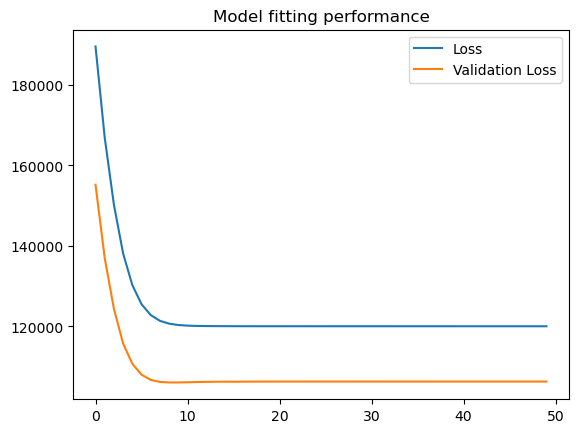

In [ ]:
axes=plt.axes()
axes.plot(pd.DataFrame(model.history.history)['loss'], label='Loss')
axes.plot(pd.DataFrame(model.history.history)['val_loss'], label='Validation Loss')
axes.legend(loc=0)
axes.set_title('Model fitting performance')